In [1]:
import numpy as np
import pandas as pd
import gensim.downloader as api
import text_hammer as th
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.layers import Embedding, Dense, Bidirectional, Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import latest_checkpoint

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')

from data_preprocessing import load_sst

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load SST dataset
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_sst()


INFO: SST-2 loaded


In [3]:
# Load into dataframes

df_train = pd.DataFrame({'content':train_data, 'sentiment':train_labels})
df_train.reset_index(drop=True, inplace=True)

df_test = pd.DataFrame({'content':dev_data, 'sentiment':dev_labels})
df_test.reset_index(drop=True, inplace=True)

df_imdb = pd.read_csv("data/IMDB Dataset.csv")
df_imdb = df_imdb.rename(columns={"review": "content"})
df_imdb['sentiment'] = df_imdb['sentiment'].map({"positive":1, "negative":0})
df_imdb.head(5)

,content,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
# Preprocessing

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def pre_processing(df):
    # Preprocessing using Text-Hammer library
    df['content'] = df['content'].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df['content'] = df['content'].progress_apply(lambda x: th.remove_emails(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_html_tags(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_urls(x))

    df['content'] = df['content'].progress_apply(lambda x: th.remove_special_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_accented_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.make_base(x)) #ran -> run, 
    # df['content'] = df['content'].progress_apply(lambda x: th.spelling_correction(x).raw_sentences[0]) #seplling -> spelling
    print("Number of words with stopwords:",df['content'].str.split().str.len().sum())
    df["content"] = df['content'].progress_apply(lambda x: remove_stopwords(x))
    print("Number of words without stopwords:",df['content'].str.split().str.len().sum())

# pre_processing(df_train)
# pre_processing(df_test)
# pre_processing(df_imdb)

In [5]:
# Load word2Vec
# model_type = 'glove-wiki-gigaword-200'  # 25 100 200 word2vec 300 
model_type = 'word2vec-google-news-300'  # 25 100 200 word2vec 300 

w2vModel = api.load(model_type)
GLOVE_DIM = int(model_type.split('-')[-1])

INFO: loading projection weights from C:\Users\Kiann/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\word2vec-google-news-300\\word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-04-07T11:59:08.894989', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


In [6]:
# Configs
max_sent_length = 50
max_number_of_sent = 50
max_number_of_words = 50000
np.random.seed(123)


In [7]:
def Tokenize(texts, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index):
    articles = texts.map(lambda x: sent_tokenize(x))

    data = np.zeros((len(texts), max_number_of_sent, max_sent_length), dtype='int32')
    failCount = 0
    for i, sentences in enumerate(articles):
        for j, sent in enumerate(sentences):
            if j< max_number_of_sent:
                wordTokens = text_to_word_sequence(sent)
                k=0
                for _, word in enumerate(wordTokens):
                    try:
                      if k<max_sent_length and tokenizer.word_index[word]<max_number_of_words:
                            data[i,j,k] = tokenizer.word_index[word]
                            k=k+1
                    except:
                      data[i,j,k] = 0
                      k=k+1
                      failCount+=1
    print('No. of %s unique tokens.' % len(word_index))
    print(f'Failed to tokenize {failCount} words')
    return data

In [10]:
# Tokenize all data for HAN

texts = df_train['content']
test_text = df_test['content']
imdb_text = df_imdb['content']

# Get all sentences
test_articles = test_text.map(lambda x: sent_tokenize(x))

# Create 3D data with tokenizer word_index. Neglect words which are not in word_index
tokenizer = Tokenizer(num_words=max_number_of_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Tokenize train test data
data = Tokenize(texts, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)
test_data = Tokenize(test_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, word_index)

# Just to get the unique token count, still use original tokenizer
imdb_tokenizer = Tokenizer(num_words=max_number_of_words)
imdb_tokenizer.fit_on_texts(imdb_text)
imdb_word_index = imdb_tokenizer.word_index

imdb_data = Tokenize(imdb_text, max_sent_length, max_number_of_sent, max_number_of_words, tokenizer, imdb_word_index)

No. of 13822 unique tokens.
Failed to tokenize 0 words
No. of 13822 unique tokens.
Failed to tokenize 842 words
No. of 124252 unique tokens.
Failed to tokenize 1218545 words


In [11]:
def Train_Val_Split(data, ori_df, val_size = 0.2):
    # Encode labels
    labels = to_categorical(np.asarray(ori_df['sentiment']))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    # Shuffle data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # Split dataset
    if(val_size == 0):
        return data, labels, None, None
    
    nb_validation_samples = int(val_size * data.shape[0])

    xtrain = data[:-nb_validation_samples]
    ytrain = labels[:-nb_validation_samples]
    xval = data[-nb_validation_samples:]
    yval = labels[-nb_validation_samples:]
    return xtrain, ytrain, xval, yval

xtrain, ytrain, xval, yval = Train_Val_Split(data,df_train)
xtest, ytest, _, _ = Train_Val_Split(test_data,df_test, 0)
xtrain_imdb, ytrain_imdb, _, _ = Train_Val_Split(imdb_data,df_imdb,0)

Shape of data tensor: (67349, 50, 50)
Shape of label tensor: (67349, 2)
Shape of data tensor: (872, 50, 50)
Shape of label tensor: (872, 2)
Shape of data tensor: (50000, 50, 50)
Shape of label tensor: (50000, 2)


In [12]:
wordLen = len(tokenizer.word_index)+1
wordLen

13823

In [13]:
## Create an embedding weight matrix based on word2vec that used in a Keras Embedding layer. 

def embed(model, tokenizer):
    embed_size = GLOVE_DIM
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embed_size))

    hits = 0
    misses = 0

    # embedding matrix
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        except:
            misses += 1
        
            
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


embedding_matrix = embed (w2vModel, tokenizer)
# embedding_matrix

Converted 12733 words (1089 misses)


In [14]:
# Loads the weights
embedding_layer = Embedding(wordLen, output_dim=GLOVE_DIM, input_length=max_sent_length, weights=[embedding_matrix],trainable=False)

# Hierarchal Attention Network word-sentence layers
# Word
sentence_input = Input(shape=(max_sent_length,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_layer = Bidirectional(layer=LSTM(100,dropout=.3))(embedded_sequences)
sentEncoder = Model(sentence_input, lstm_layer)

# Sentence
article_input = Input(shape=(max_number_of_sent,max_sent_length), dtype='int32')
article_encoder = TimeDistributed(sentEncoder)(article_input)
lstm_layer_sent = Bidirectional(LSTM(100,dropout=.3))(article_encoder)
preds = Dense(len(df_train['sentiment'].unique()), activation='softmax')(lstm_layer_sent)
han_model = Model(article_input, preds)


han_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print(han_model.summary())

# Create early stopping callback
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
# Create model checkpoint callback 
cp_callback = ModelCheckpoint(filepath="training_1/cp.ckpt",save_weights_only=True,verbose=1)


# Fit training model to SST dataset

# if not os.listdir(checkpoint_path.split("/")[0]):
history = han_model.fit(xtrain, ytrain, epochs=200, batch_size=64, verbose=1,validation_data=(xval,yval),callbacks= [es, cp_callback])
# else:
#   latest = latest_checkpoint(checkpoint_path.split("/")[0])
#   han_model.load_weights(latest)
#   history = han_model.evaluate(xval, yval, verbose=2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 200)          4467700   
 ibuted)                                                         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 4,708,902
Trainable params: 562,002
Non-trainable params: 4,146,900
_________________________________________________________________
None
Epoch 1/200
842/842 [=================

In [15]:
last_accuracy = "{:.3f}".format(history.history['acc'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.956


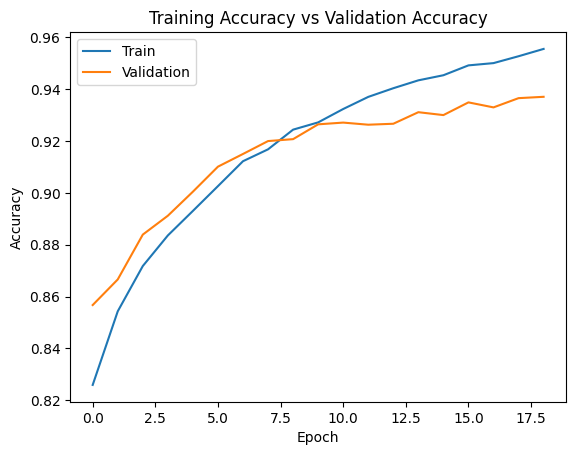

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

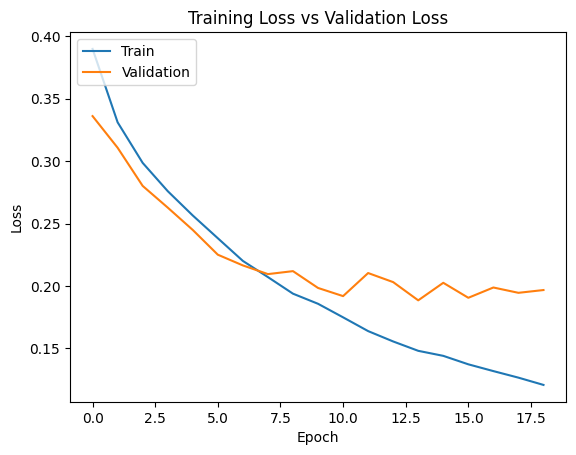

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
# Evaluate model on sst test dataset

result = han_model.evaluate(xtest, ytest, verbose=2)


28/28 - 1s - loss: 0.5281 - acc: 0.8372 - 885ms/epoch - 32ms/step


In [19]:
# Evaluate model on imdb dataset
print(xtrain_imdb.shape)
print(ytrain_imdb.shape)

result = han_model.evaluate(xtrain_imdb, ytrain_imdb, verbose=2)


(50000, 50, 50)
(50000, 2)
1563/1563 - 48s - loss: 0.9520 - acc: 0.7685 - 48s/epoch - 31ms/step
